Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Init transformation matrices

In [ ]:
# Define rotation matrices
def Rx(q):
    T = np.array([[1, 0, 0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q), np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def Ry(q):
    T = np.array([[np.cos(q), 0, np.sin(q), 0],
                  [0, 1, 0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q), np.cos(q), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T

# Define transformation matrices
def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T

Init K-matrices

In [ ]:
# Define stiffness matrices

def GetK11(E, G, A, Iy, Iz, Ip, link_length):
    K = np.array([[E * A / link_length, 0, 0, 0, 0, 0],
                  [0, 12 * E * Iz / (link_length ** 3), 0, 0, 0, 6 * E * Iz / (link_length ** 2)],
                  [0, 0, 12 * E * Iy / (link_length ** 3), 0, -6 * E * Iy / (link_length ** 2), 0],
                  [0, 0, 0, G * Ip / link_length, 0, 0],
                  [0, 0, -6 * E * Iy / (link_length ** 2), 0, 4 * E * Iy / link_length, 0],
                  [0, 6 * E * Iz / (link_length ** 2), 0, 0, 0, 4 * E * Iz / link_length]])
    return K


def GetK12(E, G, A, Iy, Iz, Ip, link_length):
    K = np.array([[-E * A / link_length, 0, 0, 0, 0, 0],
                  [0, -12 * E * Iz / (link_length ** 3), 0, 0, 0, 6 * E * Iz / (link_length ** 2)],
                  [0, 0, -12 * E * Iy / (link_length ** 3), 0, -6 * E * Iy / (link_length ** 2), 0],
                  [0, 0, 0, -G * Ip / link_length, 0, 0],
                  [0, 0, 6 * E * Iy / (link_length ** 2), 0, 2 * E * Iy / link_length, 0],
                  [0, -6 * E * Iz / (link_length ** 2), 0, 0, 0, 2 * E * Iz / link_length]])
    return K


def GetK21(E, G, A, Iy, Iz, Ip, link_length):
    return np.transpose(GetK12(E, G, A, Iy, Iz, Ip, link_length))


def GetK22(E, G, A, Iy, Iz, Ip, link_length):
    K = np.array([[E * A / link_length, 0, 0, 0, 0, 0],
                  [0, 12 * E * Iz / (link_length ** 3), 0, 0, 0, -6 * E * Iz / (link_length ** 2)],
                  [0, 0, 12 * E * Iy / (link_length ** 3), 0, 6 * E * Iy / (link_length ** 2), 0],
                  [0, 0, 0, G * Ip / link_length, 0, 0],
                  [0, 0, 6 * E * Iy / (link_length ** 2), 0, 4 * E * Iy / link_length, 0],
                  [0, -6 * E * Iz / (link_length ** 2), 0, 0, 0, 4 * E * Iz / link_length]])
    return K

Inverse kinematic

In [ ]:
# Calculate local inverse kinematic
def getInverseKinematic(leg_bases, platform_edges, links):
    legs_q = []

    for i in range(len(leg_bases)):
        base = leg_bases[i]
        r_base = base[0:3, 0:3]
        p_base = base[0:3, 3]

        xlocal, ylocal, zlocal = np.transpose(r_base).dot(platform_edges[i] - p_base)

        cos_q2 = (xlocal ** 2 + ylocal ** 2 - links[0] ** 2 - links[1] ** 2) / (2 * links[0] * links[1])
        sin_q2 = np.sqrt(1 - cos_q2 ** 2)

        q2 = np.arctan2(sin_q2, cos_q2)
        q1 = np.arctan2(ylocal, xlocal) - np.arctan2(links[1] * np.sin(q2), links[0] + links[1] * np.cos(q2))
        q3 = -(q1 + q2)

        leg_q = np.array([q1, q2, q3])
        legs_q.append(leg_q)

    return legs_q

Get FK for every link

In [ ]:
def getLinkTransformations(base, links, q, ee_pos):
    link_1 = np.linalg.multi_dot([base, Tz(ee_pos), Rz(q[0])])
    link_2 = np.linalg.multi_dot([link_1, Tx(links[0]), Rz(q[1])])
    link_3 = np.linalg.multi_dot([link_2, Tx(links[1]), Rz(q[2])])

    return link_1, link_2, link_3

Q matrix calculations

In [ ]:
def getMatrixQ(bases, ee_positions, legs_q, links):
    Q = []

    for i in range(len(bases)):
        base = bases[i]
        q = legs_q[i]
        ee_pos = ee_positions[i]

        link_1, link_2, link_3 = getLinkTransformations(base, links, q, ee_pos)
        rotation_link_1 = link_1[0:3, 0:3]
        rotation_link_2 = link_2[0:3, 0:3]

        zeros = np.zeros((3, 3))

        Q_1 = np.vstack([np.hstack([rotation_link_1, zeros]),
                         np.hstack([zeros, rotation_link_1])])

        Q_2 = np.vstack([np.hstack([rotation_link_2, zeros]),
                         np.hstack([zeros, rotation_link_2])])

        Q.append([Q_1, Q_2])

    return Q

Kc calculation

In [ ]:
def getKc(Q, K11, K12, K21, K22, lmbda_e_12, lmbda_r_12, lmbda_r_34, lmbda_r_56, lmbda_r_78,
                   lmbda_p_34, lmbda_p_56, lmbda_p_78, D_8e):
    Kc = []
    for i in range(len(Q)):

        Q1 = Q[i][0]
        K11_45 = np.linalg.multi_dot([Q1, K11, np.transpose(Q1)])
        K12_45 = np.linalg.multi_dot([Q1, K12, np.transpose(Q1)])
        K21_45 = np.linalg.multi_dot([Q1, K21, np.transpose(Q1)])
        K22_45 = np.linalg.multi_dot([Q1, K22, np.transpose(Q1)])

        Q2 = Q[i][1]
        K11_67 = np.linalg.multi_dot([Q2, K11, np.transpose(Q2)])
        K12_67 = np.linalg.multi_dot([Q2, K12, np.transpose(Q2)])
        K21_67 = np.linalg.multi_dot([Q2, K21, np.transpose(Q2)])
        K22_67 = np.linalg.multi_dot([Q2, K22, np.transpose(Q2)])

        row1 = np.hstack([np.zeros((6, 6 * 9)), np.eye(6), np.zeros((6, 6 * 7))])
        row2 = np.hstack([np.zeros((6, 6 * 3)), -np.eye(6), np.zeros((6, 6 * 8)), K11_45, K12_45, np.zeros((6, 6 * 3))])
        row3 = np.hstack([np.zeros((6, 6 * 4)), -np.eye(6), np.zeros((6, 6 * 7)), K21_45, K22_45, np.zeros((6, 6 * 3))])
        row4 = np.hstack([np.zeros((6, 6 * 5)), -np.eye(6), np.zeros((6, 6 * 8)), K11_67, K12_67, np.zeros((6, 6*1))])
        row5 = np.hstack([np.zeros((6, 6 * 6)), -np.eye(6), np.zeros((6, 6 * 7)), K21_67, K22_67, np.zeros((6, 6*1))])
        row6 = np.hstack([np.zeros((6, 6 * 16)), D_8e[i]])

        row7 = np.hstack([np.zeros((6, 6 * 7)), np.eye(6), np.transpose(D_8e[i]), np.zeros((6, 6 * 8))])
        row8 = np.hstack([np.zeros((6, 6 * 10)), np.eye(6), -np.eye(6), np.zeros((6, 6 * 5))])
        row9 = np.hstack([np.zeros((6, 6 * 1)), np.eye(6), np.eye(6), np.zeros((6, 6 * 14))])
        row10 = np.hstack([np.zeros((5, 6 * 9)), lmbda_r_12[i], -lmbda_r_12[i], np.zeros((5, 6 * 6))])
        row11 = np.hstack([np.eye(6), np.eye(6), np.zeros((6, 6 * 15))])
        row12 = np.hstack([lmbda_e_12[i], np.zeros((6 * 8)), K_active * lmbda_e_12[i], -K_active * lmbda_e_12[i],
                           np.zeros((6 * 6))])

        row13 = np.hstack([np.zeros((5, 6 * 11)), lmbda_r_34[i], -lmbda_r_34[i], np.zeros((5, 6 * 4))])
        row14 = np.hstack([np.zeros((5, 6 * 2)), lmbda_r_34[i], lmbda_r_34[i], np.zeros((5, 6 * 13))])
        row15 = np.hstack([np.zeros((6 * 2)), lmbda_p_34[i], np.zeros((6 * 14))])
        row16 = np.hstack([np.zeros((6 * 3)), lmbda_p_34[i], np.zeros((6 * 13))])
        row17 = np.hstack([np.zeros((5, 6 * 13)), lmbda_r_56[i], -lmbda_r_56[i], np.zeros((5, 6 * 2))])
        row18 = np.hstack([np.zeros((5, 6 * 4)), lmbda_r_56[i], lmbda_r_56[i], np.zeros((5, 6 * 11))])
        row19 = np.hstack([np.zeros((6 * 4)), lmbda_p_56[i], np.zeros((6 * 12))])
        row20 = np.hstack([np.zeros((6 * 5)), lmbda_p_56[i], np.zeros((6 * 11))])

        row21 = np.hstack([np.zeros((5, 6 * 15)), lmbda_r_78[i], -lmbda_r_78[i]])
        row22 = np.hstack([np.zeros((5, 6 * 6)), lmbda_r_78[i], lmbda_r_78[i], np.zeros((5, 6 * 9))])
        row23 = np.hstack([np.zeros((6 * 6)), lmbda_p_78[i], np.zeros((6 * 10))])
        row24 = np.hstack([np.zeros((6 * 7)), lmbda_p_78[i], np.zeros((6 * 9))])

        A = np.vstack([row1, row2, row3, row4, row5, row6, row7, row8, row9,
                       row10, row11, row12, row13, row14, row15, row16, row17,
                       row18, row19, row20, row21, row22, row23, row24])

        B = np.vstack([np.zeros((30, 6)), -np.eye(6), np.zeros((66, 6))])

        C = np.hstack([np.zeros((6, 6 * 8)), -np.eye(6), np.zeros((6, 6 * 8))])

        D = np.zeros((6, 6 * 1))

        A_inv = np.linalg.inv(A)
        New = np.dot(C, A_inv)
        K_one = D - np.dot(New, B)
        Kc.append(K_one)

    Kc = Kc[0] + Kc[1] + Kc[2]
    return Kc

Calculate shift from center to platform edges

In [ ]:
def GetPlatformEdges(position):
    posForArmX = [position[0], position[1], position[2]]
    posForArmX[1] += np.sqrt(0.1 ** 2 - 0.05 ** 2)
    posForArmX[0] += 0.05

    posForArmY = [position[0], position[1], position[2]]
    posForArmY[0] -= 0.1

    posForArmZ = [position[0], position[1], position[2]]
    posForArmZ[1] -= np.sqrt(0.1 ** 2 - 0.05 ** 2)
    posForArmZ[0] += 0.05

    return [posForArmX, posForArmY, posForArmZ]

Plot Tripteron sheme

In [ ]:
def plotModel(bases, ee_pos, legs_q, link, platform_nodes):
    plt.figure()
    ax = plt.axes(projection='3d')

    ax.set_xlim3d(-0.5, space_x + 0.5)
    ax.set_ylim3d(-0.5, space_y + 0.5)
    ax.set_zlim3d(-0.5, space_z + 0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for i in range(len(bases)):
        q = legs_q[i]
        base = bases[i]

        toPassive1, toPassive2, toPassive3 = getLinkTransformations(base, link, q, platform_nodes[i][i])
        link_1 = toPassive1[0:3, 3]
        link_2 = toPassive2[0:3, 3]
        link_3 = toPassive3[0:3, 3]

        # Plot links
        leg = [[], [], []]
        for i in range(len(leg)):
            leg[i].append(link_1[i])
            leg[i].append(link_2[i])
            leg[i].append(link_3[i])

        ax.plot3D(leg[0], leg[1], leg[2], c='indigo', linewidth=2)

        # Plot bases
        active = [[], [], []]
        for i in range(len(leg)):
            active[i].append(base[0:3, 3][i])
            active[i].append(link_1[i])

        ax.plot3D(active[0], active[1], active[2], c='navy', linewidth=3)

    # Plot platform
    for i in range(len(platform_nodes)):
        curNode = platform_nodes[i]
        nextNode = platform_nodes[(i + 1) % len(platform_nodes)]

        x_values = [curNode[0], nextNode[0]]
        y_values = [curNode[1], nextNode[1]]
        z_values = [curNode[2], nextNode[2]]

        plt.plot(x_values, y_values, z_values, color='black', linewidth=2)

    # End-effector pos
    ax.scatter3D(ee_pos[0], ee_pos[1], ee_pos[2], c='red', s=8)

Plot deflection map

In [ ]:
def plotDeflectionMap(x_pos, y_pos, z_pos, deflection, colormap, s):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0, space_x)
    ax.set_ylim3d(0, space_y)
    ax.set_zlim3d(0, space_z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.colorbar(ax.scatter3D(x_pos, y_pos, z_pos, c=deflection, cmap=colormap, s=s))
    plt.show()

Main deflection calculations

In [ ]:
def CalculateDeflections(links, forces):
    x_pos = np.array([])
    y_pos = np.array([])
    z_pos = np.array([])
    deflections = np.array([])

    xlinSpace = np.linspace(0.001, 1, 16)
    ylinSpace = np.linspace(0.001, 1, 16)
    zlinSpace = np.linspace(0.001, 1, 16)

    for x in xlinSpace:
        xData = np.array([])
        yData = np.array([])
        zData = np.array([])
        dData = np.array([])

        for y in ylinSpace:
            for z in zlinSpace:
                end_eff_pos = np.array([x, y, z])
                platform_edges = GetPlatformEdges(end_eff_pos)
                ik_q = getInverseKinematic(T_base, platform_edges, links)

                # plotTripteron(T_base, p_global, q_passive, theta, link, p_fake_global)

                Q = getMatrixQ(T_base, end_eff_pos, ik_q, links)

                Kc = getKc(Q, K11, K12, K21, K22, lambda_e_12, lambda_r_12, lambda_r_34, lambda_r_56, lambda_r_78,
                           lambda_p_34, lambda_p_56, lambda_p_78, D8e)

                dt = np.linalg.inv(Kc).dot(forces)
                deflection = np.sqrt(dt[0] ** 2 + dt[1] ** 2 + dt[2] ** 2)

                xData = np.append(xData, x)
                yData = np.append(yData, y)
                zData = np.append(zData, z)
                dData = np.append(dData, deflection)

        x_pos = np.append(x_pos, xData)
        y_pos = np.append(y_pos, yData)
        z_pos = np.append(z_pos, zData)
        deflections = np.append(deflections, dData)

    return x_pos, y_pos, z_pos, deflections

Init lambdas

In [ ]:
lambda_r_12_x = np.array([[0, 1, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

lambda_e_12_x = np.array([1, 0, 0, 0, 0, 0])

lambda_r_12_y = np.array([[1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

lambda_e_12_y = np.array([0, 1, 0, 0, 0, 0])

lambda_r_12_z = np.array([[1, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

lambda_e_12_z = np.array([0, 0, 1, 0, 0, 0])

lambda_r_12 = [lambda_r_12_x, lambda_r_12_y, lambda_r_12_z]
lambda_e_12 = [lambda_e_12_x, lambda_e_12_y, lambda_e_12_z]

lambda_r_34_x = np.array([[1, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 1]])

lambda_r_56_x = lambda_r_78_x = lambda_r_34_x
lambda_p_34_x = lambda_p_56_x = lambda_p_78_x = np.array([0, 0, 0, 1, 0, 0])

lambda_r_34_y = np.array([[1, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 1]])

lambda_r_56_y = lambda_r_78_y = lambda_r_34_y
lambda_p_34_y = lambda_p_56_y = lambda_p_78_y = np.array([0, 0, 0, 0, 1, 0])

lambda_r_34_z = np.array([[1, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 1, 0]])

lambda_r_56_z = lambda_r_78_z = lambda_r_34_z
lambda_p_34_z = lambda_p_56_z = lambda_p_78_z = np.array([0, 0, 0, 0, 0, 1])

lambda_r_34 = [lambda_r_34_x, lambda_r_34_y, lambda_r_34_z]
lambda_r_56 = [lambda_r_56_x, lambda_r_56_y, lambda_r_56_z]
lambda_r_78 = [lambda_r_78_x, lambda_r_78_y, lambda_r_78_z]

lambda_p_34 = [lambda_p_34_x, lambda_p_34_y, lambda_p_34_z]
lambda_p_56 = [lambda_p_56_x, lambda_p_56_y, lambda_p_56_z]
lambda_p_78 = [lambda_p_78_x, lambda_p_78_y, lambda_p_78_z]

Init matrix D8e

In [ ]:
dx = np.array([[0, 0, -np.sqrt(0.1 ** 2 - 0.05 ** 2)], [0, 0, 0.05], [np.sqrt(0.1 ** 2 - 0.05 ** 2), -0.05, 0]])
Dx = np.vstack([np.hstack([np.eye(3), dx]), np.hstack([np.zeros((3, 3)), np.eye(3)])])

dy = np.array([[0, 0, 0], [0, 0, 0.1], [0, -0.1, 0]])
Dy = np.vstack([np.hstack([np.eye(3), dy]), np.hstack([np.zeros((3, 3)), np.eye(3)])])

dz = np.array([[0, 0, np.sqrt(0.1 ** 2 - 0.05 ** 2)], [0, 0, 0.05], [-np.sqrt(0.1 ** 2 - 0.05 ** 2), -0.05, 0]])
Dz = np.vstack([np.hstack([np.eye(3), dz]), np.hstack([np.zeros((3, 3)), np.eye(3)])])

D8e = [Dx, Dy, Dz]

Initialize constant values

In [ ]:
space_x = space_y = space_z = 1.0

T_base_z = np.eye(4)
T_base_y = np.linalg.multi_dot([Tz(space_z), Rx(-np.pi / 2)])
T_base_x = np.linalg.multi_dot([Ty(space_y), Ry(np.pi / 2), Rz(np.pi)])
T_base = [T_base_x, T_base_y, T_base_z]

K_active = 1000000

e = 6.90000e+10
g = 2.5500e+10

link_lengths = np.array([1, 1])
d_link = 0.15
a = np.pi * (d_link ** 2) / 4
i_y = np.pi * (d_link ** 4) / 64
i_z = np.pi * (d_link ** 4) / 64
i_p = i_y + i_z

K11 = GetK11(e, g, a, i_y, i_z, i_p, link_lengths[0])
K12 = GetK12(e, g, a, i_y, i_z, i_p, link_lengths[0])
K21 = GetK21(e, g, a, i_y, i_z, i_p, link_lengths[0])
K22 = GetK22(e, g, a, i_y, i_z, i_p, link_lengths[0])

  Def telegram function 

In [ ]:
def telegram(message):
    import requests
    CHAT_ID=-493875817
    BOT_TOKEN='1607463802:AAEZFeKtjfiAk0_jYTq8xFTv8iXd-uWc1mU'
    params = {"chat_id": CHAT_ID, "text": str(message)}
    requests.get(f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage", params=params)


Robot sheme

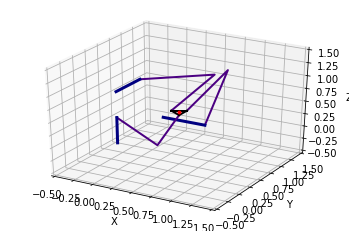

In [ ]:
# Calculations
p_global = np.array([0.5, 0.5, 0.5])
p_fake_global = GetPlatformEdges(p_global)
q_passive = getInverseKinematic(T_base, p_fake_global, link_lengths)

plotModel(T_base, p_global, q_passive, link_lengths, p_fake_global)

Final output

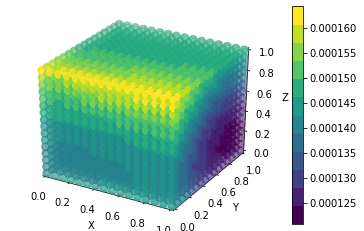

In [ ]:
externalForce = np.array([[100], [0], [0], [0], [0], [0]])
x, y, z, d = CalculateDeflections(link_lengths, externalForce)

clmap = plt.cm.get_cmap('viridis', 12)
plotDeflectionMap(x, y, z, d, clmap, 60)



telegram('code is ready')